<a href="https://colab.research.google.com/github/tiboas/KmeansForQAM/blob/main/K_means_clustering_for_QAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install komm
#https://komm.readthedocs.io/en/latest/komm.AWGNChannel/

import komm as komm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random

     |████████████████████████████████| 50 kB 2.7 MB/s 
  Created wheel for komm: filename=komm-0.7.1-py3-none-any.whl size=56608 sha256=6bde3a59844e31cafabb1efa2c13f469f4fc2983f61d97a07ce73405c6710586
  Stored in directory: /root/.cache/pip/wheels/67/d6/14/a8e4b0235b3dc3c8a28c4e2059b66ad5b8c262df15df54f843
Successfully built komm


In [2]:
#Settings
SNRdB = 20
Nsamples = 10000
M = 16 #number of constellation points, i.e. 16-QAM
# Note that currently the notebook onyl supports M up to 16 due to the manually defined color palette

#Set seed:
random.seed(42)
np.random.seed(42)

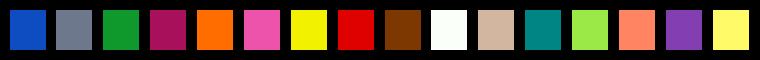

In [3]:
#Define a color palett for constellation plots:
def returnHex(C):
    return '#' + ''.join(f'{c:02x}' for c in C)

C =np.array([[14,77,193], [110,120,141],[15,153,45],  [168,16,91],
             [255, 108,0],[237,83,170], [242,242,0],  [223,0,0],
             [125,55,0],  [251,255,250],   [210,182,159],[0,133,133],
             [155,233,71],[255,133,98], [131,62,178], [255,250,103]]) / 255
wdt=75*10
colorImg = Image.new(mode="RGB", size=(wdt+10,60))
for i in range(16):
    temp = Image.new(mode="RGB", size=(int(wdt/16)-10,40), color=returnHex(np.int64(C[i]*255)))
    colorImg.paste(temp, (int(i*wdt/16)+10,10))
colorImg

In [4]:
# Function to plot constellations, with color coding for which cluster the points belong to, 
# and visualization of the found means.
def constPlotter(y,x_hat,C):
  for k in range(len(C)):
    currentConst = y[x_hat==k]
    plt.plot(currentConst.real,currentConst.imag,'.',color=np.array(C[k]))
    plt.plot(c_means.real,c_means.imag,'o',color='k',markerfacecolor='w')
    plt.xticks([])
    plt.yticks([])
    plt.draw()
    plt.axis('equal')

In [5]:
awgn = komm.AWGNChannel(snr = 10**(SNRdB/10))
tx = komm.QAModulation(16) #create 16QAM transmitter

#Generate 16QAM-signal:
b = np.random.randint(0,2,Nsamples*4) # *4 since 4 16QAM has 4 bits/symbol
x = tx.modulate(b)
x = x/np.sqrt(np.mean(np.abs(x)**2)) #normalize

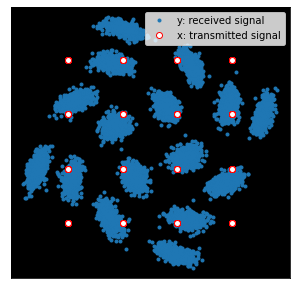

In [6]:
y = awgn(x)
y = y*np.exp(1j*abs(y)*0.75)
plt.figure(figsize=(5,5))
#plt.plot(y.real,y.imag,'.')

plt.plot(y.real,y.imag,'.')
plt.plot(x.real,x.imag,'o',color='r',markerfacecolor='w')
plt.xticks([])
plt.yticks([])
ax = plt.gca()
ax.set_facecolor((0, 0., 0))
plt.axis('equal')
plt.legend(['y: received signal','x: transmitted signal'])

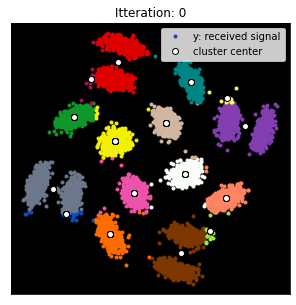

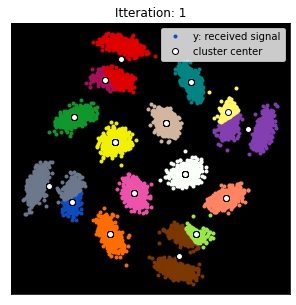

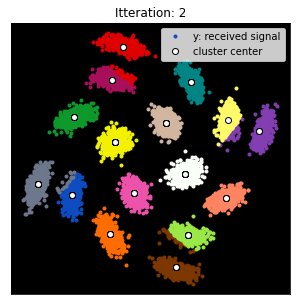

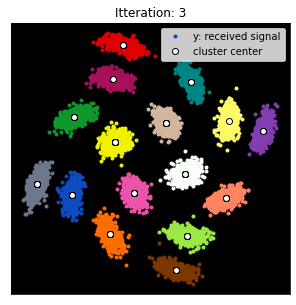

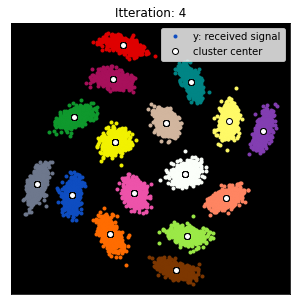

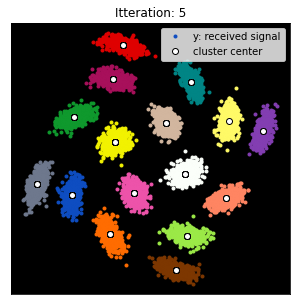

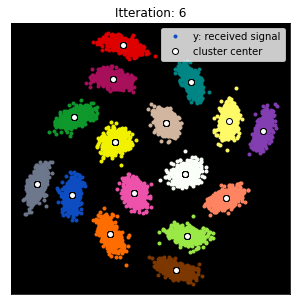

In [7]:
N_itterations = 7
c_means = np.unique(x)
M = len(c_means)
dist = np.zeros((Nsamples,M))
cost_peritt = np.zeros(N_itterations)
for n_itt in range(N_itterations):
  for k in range(M):
    dist[:,k] = np.square(np.abs(y-c_means[k]))
  
  #Decisions:
  x_hat = np.argmin(dist,1)
  cost = 0
  for k in range(M):
    c_means[k] = np.mean(y[x_hat == k])
    cost = cost + np.sum(np.abs(y[x_hat == k]-c_means[k]))
  cost_peritt[n_itt] = cost
  plt.figure(figsize=(5,5))
  constPlotter(y,x_hat,C)
  ax = plt.gca()
  ax.set_facecolor((0, 0., 0))
  plt.legend(['y: received signal','cluster center'])
  plt.title('Itteration: ' + str(n_itt))

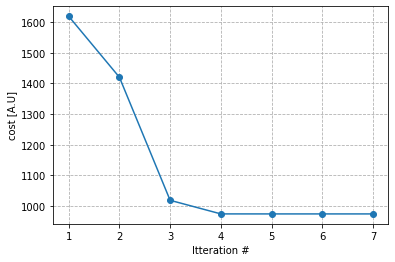

In [8]:
plt.plot(np.array(range(len(cost_peritt)))+1,cost_peritt,'o-')
plt.xticks(np.array(range(len(cost_peritt)))+1)
plt.grid('major',linestyle='--',)
plt.ylabel('cost [A.U]')
plt.xlabel('Itteration #')
plt.draw()

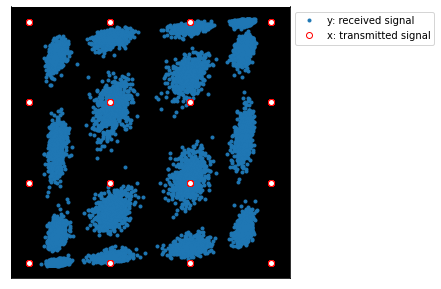

In [9]:
SNRdB = 19
awgn = komm.AWGNChannel(snr = 10**(SNRdB/10))
tx = komm.QAModulation(16) #create 16QAM transmitter

#Generate 16QAM-signal:
b = np.random.randint(0,2,Nsamples*4) # *4 since 4 16QAM has 4 bits/symbol
x = tx.modulate(b)
x = x/np.sqrt(np.mean(np.abs(x)**2)) #normalize

y = awgn(x)
y= np.tanh(y.real) + 1j*np.tanh((y*np.exp(1j*0.35)).imag*1.5)
plt.figure(figsize=(5,5))
#plt.plot(y.real,y.imag,'.')

plt.plot(y.real,y.imag,'.')
plt.plot(x.real,x.imag,'o',color='r',markerfacecolor='w')
plt.xticks([])
plt.yticks([])
ax = plt.gca()
ax.set_facecolor((0, 0., 0))
plt.axis('equal')
plt.legend(['y: received signal','x: transmitted signal'],loc="upper left", bbox_to_anchor=(1,1))


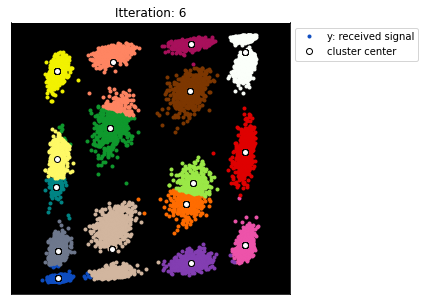

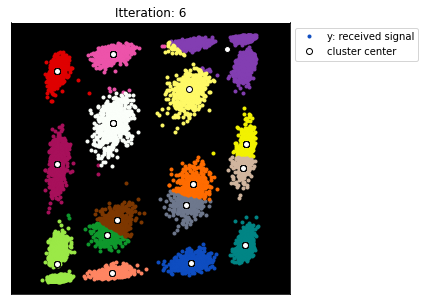

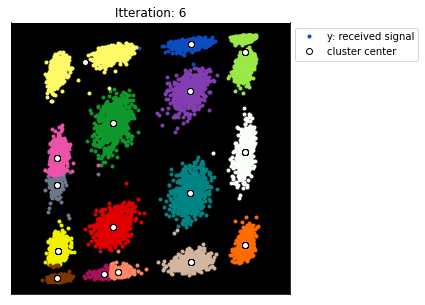

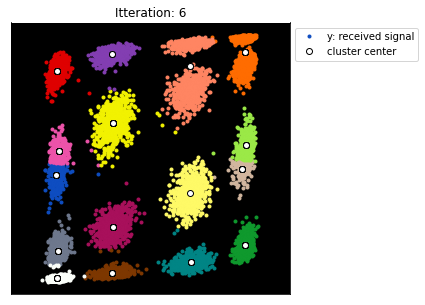

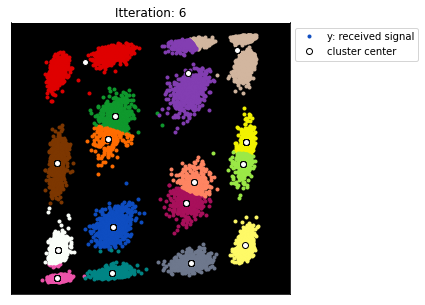

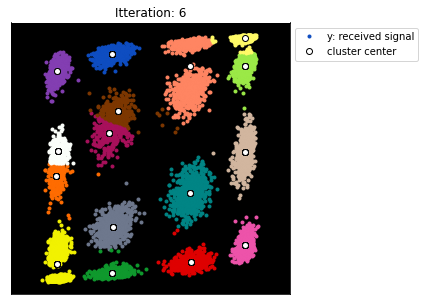

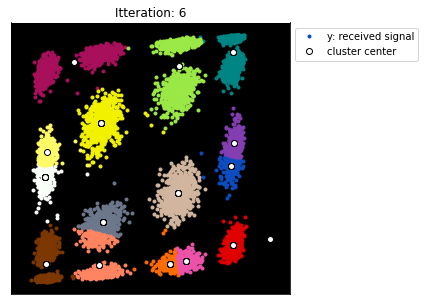

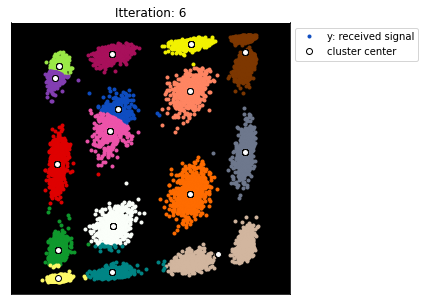

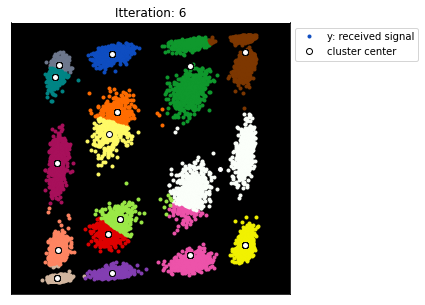

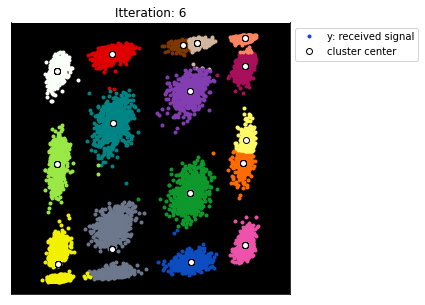

In [10]:
N_itterations = 7
N_random_starts = 10

cost_total= np.zeros((N_random_starts,N_itterations))
for n_rand in range(N_random_starts):
  c_means = np.unique(x)
  c_means = np.random.randn(16)+1j*np.random.randn(16)
  M = len(c_means)
  dist = np.zeros((Nsamples,M))
  cost_peritt = np.zeros(N_itterations)
  for n_itt in range(N_itterations):
    for k in range(M):
      dist[:,k] = np.square(np.abs(y-c_means[k]))
    
    #Decisions:
    x_hat = np.argmin(dist,1)
    cost = 0
    for k in range(M):
      if not np.any(y[x_hat == k]):
        c_means[k] = np.random.randn(1)+1j*np.random.randn(1)
      else:
        c_means[k] = np.mean(y[x_hat == k])
      cost = cost + np.sum(np.abs(y[x_hat == k]-c_means[k]))
    cost_peritt[n_itt] = cost
    cost_total[n_rand,n_itt] = cost
  plt.figure(figsize=(5,5))
  constPlotter(y,x_hat,C)
  ax = plt.gca()
  ax.set_facecolor((0, 0., 0))
  plt.legend(['y: received signal','cluster center'],loc="upper left", bbox_to_anchor=(1,1))
  plt.title('Itteration: ' + str(n_itt))

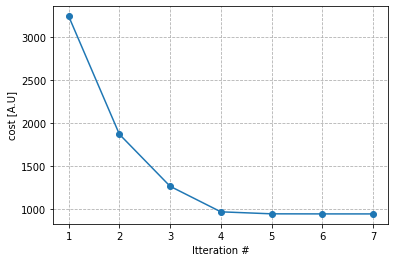

In [11]:
plt.plot(np.array(range(len(cost_peritt)))+1,cost_peritt,'o-')
plt.xticks(np.array(range(len(cost_peritt)))+1)
plt.grid('major',linestyle='--',)
plt.ylabel('cost [A.U]')
plt.xlabel('Itteration #')
plt.draw()



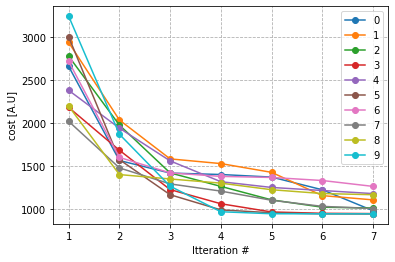

In [12]:
for k in range(N_random_starts):
  this_cost_peritt = cost_total[k,:]
  plt.plot(np.array(range(len(this_cost_peritt)))+1,this_cost_peritt,'o-')
plt.xticks(np.array(range(len(this_cost_peritt)))+1)
plt.grid('major',linestyle='--',)
plt.ylabel('cost [A.U]')
plt.xlabel('Itteration #')
plt.legend(range(N_random_starts))
plt.draw()

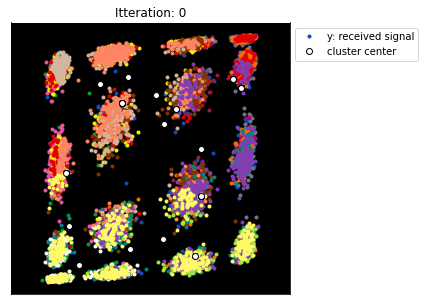

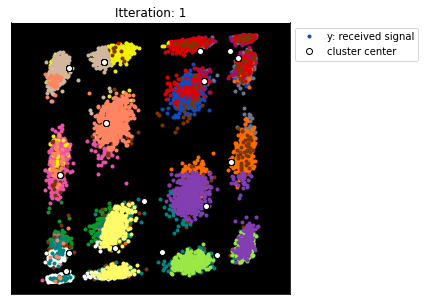

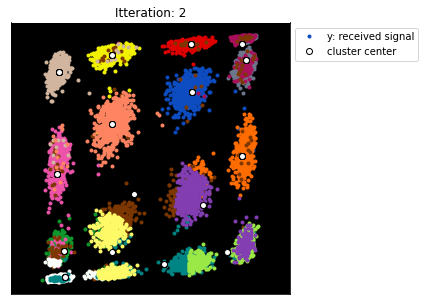

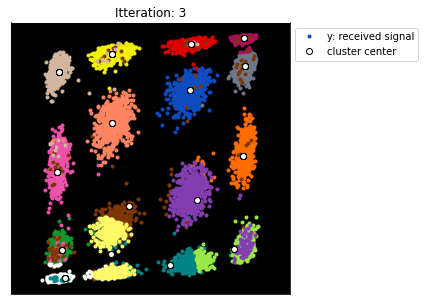

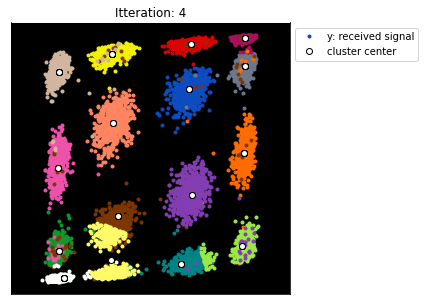

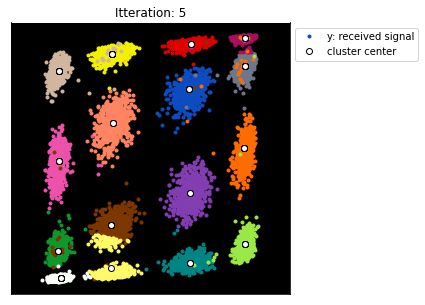

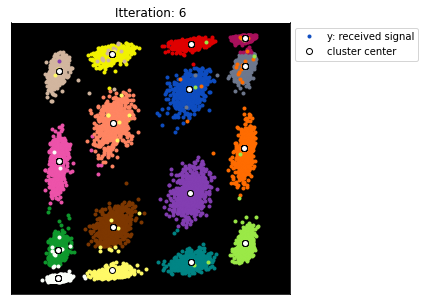

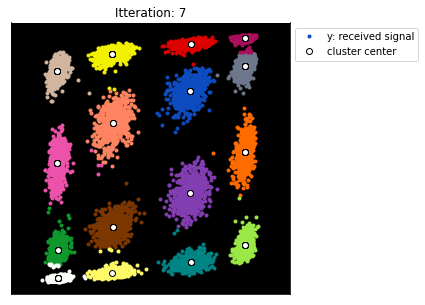

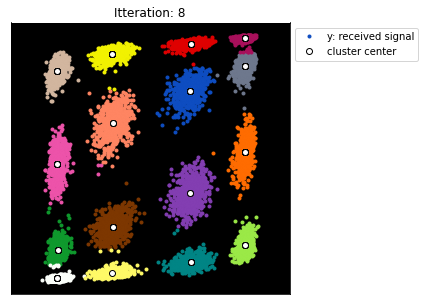

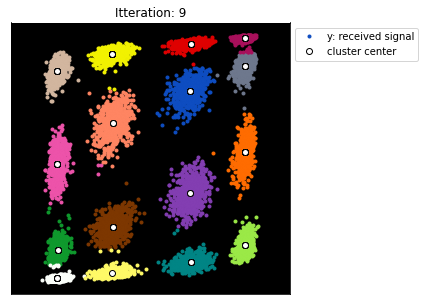

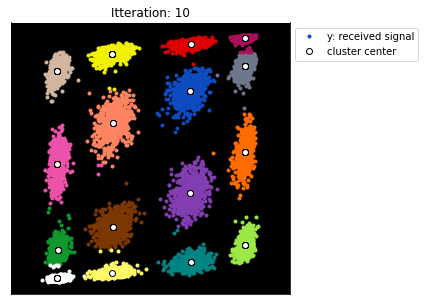

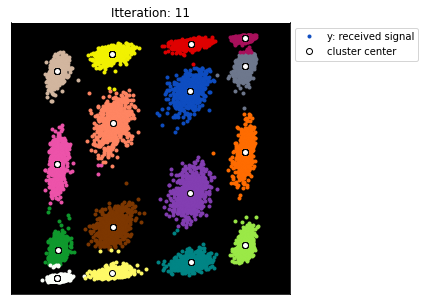

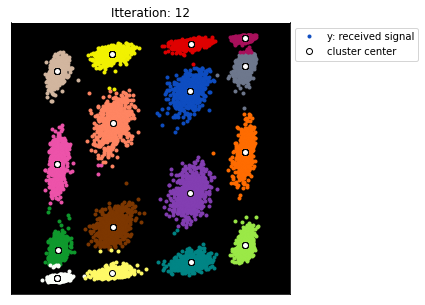

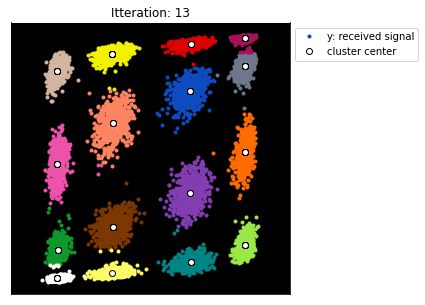

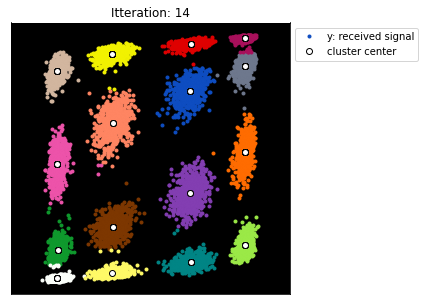

In [13]:
N_itterations = 15
N_random_starts = 1

cost_total= np.zeros((N_random_starts,N_itterations))
for n_rand in range(N_random_starts):
  c_means = np.unique(x)
  c_means = np.random.randn(16)+1j*np.random.randn(16)
  M = len(c_means)
  dist = np.zeros((Nsamples,M))
  cost_peritt = np.zeros(N_itterations)
  for n_itt in range(N_itterations):
    for k in range(M):
      dist[:,k] = np.square(np.abs(y-c_means[k]))
    
    #Decisions:
    x_hat = np.argmin(dist,1)

    # We can utilize the fact that we know that each of the M symbols should have roughly the same probability. 
    # For the first few itterations we assume that P(M) = 1/M. 
    # However, we turn off this critera once after a few itterations to account for that in one batch of random data we dont have exactly 1/M sampels per constellation point. 
    if n_itt<7:
      Nmax = int(Nsamples/M)
      Ncount = np.zeros(16)
      for l in range(Nsamples):
        crit = 1
        while crit:
          dec = np.argmin(dist[l,:])
          if Ncount[dec] > Nmax:
            dist[l,dec] = 1e99 #really large number
          else:
            crit = 0    
        Ncount[dec]+=1       
        x_hat[l] = dec





    cost = 0
    for k in range(M):
      if not np.any(y[x_hat == k]):
        c_means[k] = np.random.randn(1)+1j*np.random.randn(1)
      else:
        c_means[k] = np.mean(y[x_hat == k])
      cost = cost + np.sum(np.abs(y[x_hat == k]-c_means[k]))
    cost_peritt[n_itt] = cost
    cost_total[n_rand,n_itt] = cost
    plt.figure(figsize=(5,5))
    constPlotter(y,x_hat,C)
    ax = plt.gca()
    ax.set_facecolor((0, 0., 0))
    plt.legend(['y: received signal','cluster center'],loc="upper left", bbox_to_anchor=(1,1))
    plt.title('Itteration: ' + str(n_itt))

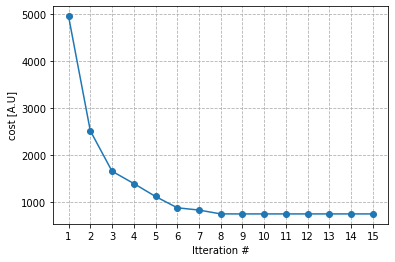

In [14]:
plt.plot(np.array(range(len(cost_peritt)))+1,cost_peritt,'o-')
plt.xticks(np.array(range(len(cost_peritt)))+1)
plt.grid('major',linestyle='--',)
plt.ylabel('cost [A.U]')
plt.xlabel('Itteration #')
plt.draw()

